## Running MOVE and analyze the latent space

This notebook runs part of the Multi-Omics Variational autoEncoder (MOVE) framework for training the model for integrating the data into the latent space, plotting the results and analyse the important variables for the integration- Before running this code the optimal hyperparameters need to be identified as described in the notebookes <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i> and <i>MOVE_hyperparameter_optimization_stability.ipynb</i>.

Importing the packages

In [1]:
from hydra import initialize, compose

from move.training.train import train_model
from move.utils.data_utils import get_data, merge_configs
from move.utils.visualization_utils import embedding_plot_discrete, embedding_plot_float, visualize_training, plot_reconstruction_distribs, visualize_embedding, plot_categorical_importance, plot_continuous_importance
from move.utils.analysis import get_latents, calc_categorical_reconstruction_acc, calc_continuous_reconstruction_acc, get_embedding, get_pearsonr, get_feature_importance_categorical, get_feature_importance_continuous, save_feat_results, get_feat_importance_on_weights 

import numpy as np

The notebook reads a default config and then overrides with user-defined configs in data.yaml, model.yaml and training_latent.yaml files. Finally, it reads the needed variables. 

In [2]:
# Initializing the default config 
with initialize(version_base=None, config_path="../src/move/conf"):
    base_config = compose(config_name="main")
    
# Overriding base_config with the user defined configs.
cfg = merge_configs(base_config=base_config, 
            config_types=['data', 'model', 'training_latent'])

#Getting the variables used in the notebook
interim_data_path = cfg.data.interim_data_path
processed_data_path = cfg.data.processed_data_path
headers_path = cfg.data.headers_path

data_of_interest = cfg.data.data_of_interest
categorical_names = cfg.data.categorical_names
continuous_names = cfg.data.continuous_names
categorical_weights = cfg.data.categorical_weights
continuous_weights = cfg.data.continuous_weights  
features_to_visualize = cfg.data.data_features_to_visualize_notebook4

seed = cfg.model.seed
cuda = cfg.model.cuda   
lrate = cfg.model.lrate
kld_steps = cfg.model.kld_steps
batch_steps = cfg.model.batch_steps

nHiddens = cfg.training_latent.num_hidden
nLatents = cfg.training_latent.num_latent
nLayers = cfg.training_latent.num_layers
nDropout = cfg.training_latent.dropout
nBeta = cfg.training_latent.beta
batch_sizes = cfg.training_latent.batch_sizes
nepochs = cfg.training_latent.tuned_num_epochs 

epochs = range(1, nepochs + 1)    


Overriding the default config with configs from data.yaml, model.yaml, training_latent.yaml

Configuration used: 
---
data:
  user_config: data.yaml
  na_value: na
  raw_data_path: data/
  interim_data_path: interim_data/
  processed_data_path: processed_data/
  headers_path: headers/
  version: v1
  ids_file_name: baseline_ids.txt
  ids_has_header: false
  ids_colname: 0
  categorical_inputs:
  - name: diabetes_genotypes
    weight: 1
  - name: baseline_drugs
    weight: 1
  - name: baseline_categorical
    weight: 1
  continuous_inputs:
  - name: baseline_continuous
    weight: 2
  - name: baseline_transcriptomics
    weight: 1
  - name: baseline_diet_wearables
    weight: 1
  - name: baseline_proteomic_antibodies
    weight: 1
  - name: baseline_target_metabolomics
    weight: 1
  - name: baseline_untarget_metabolomics
    weight: 1
  - name: baseline_metagenomics
    weight: 1
  data_of_interest: baseline_drugs
  categorical_names: ${names:${data.categorical_inputs}}
  continuous_n

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. Since the patients data is not available for testing, the notebook uses a random data generated with make_random_data.py file.

In [3]:
#Getting the data
cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(headers_path, interim_data_path, categorical_names, continuous_names, data_of_interest)
# Checking if all input features selected for visualization were in headers_all
for feature in features_to_visualize:
    if feature not in np.concatenate(headers_all):
        raise ValueError(f"{feature} is not in the headers_all list. It could have been it was not among the features of the input dataset or was filtered out during data processing")
    

Initialize varriables and make model using the identified optimal hyperparameters from the optimzsation steps. Inside the function we are using equal weight for all continuous but double weight on the clinical data to ensure sufficient learning and focus of the structure of interested (Type 2 Dieabetes). 

In [4]:
# Training the model 
print('Beginning training the model.\n')
best_model, losses, ce, sse, KLD, train_loader, mask, kld_w, cat_shapes, con_shapes, best_epoch = train_model(cat_list, con_list, categorical_weights, continuous_weights, batch_sizes, nHiddens, nLayers, nLatents, nBeta, nDropout, cuda, kld_steps, batch_steps, nepochs, lrate, seed, test_loader=None, patience=None, early_stopping=False)
print('\nFinished training the model.')

Beginning training the model.

	Epoch: 1	Loss: 13.815426	CE: 3.6788374	SSE: 10.136589	KLD: 0.0000	Batchsize: 10

Finished training the model.


Visualizing the training

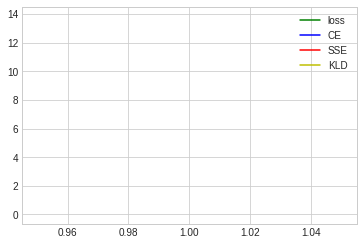

<Figure size 432x288 with 0 Axes>

In [5]:
# Visualizing the training
visualize_training(processed_data_path, losses, ce, sse, KLD, epochs)

Visualizing reconstruction distributions

====> Test set loss: 14.2348


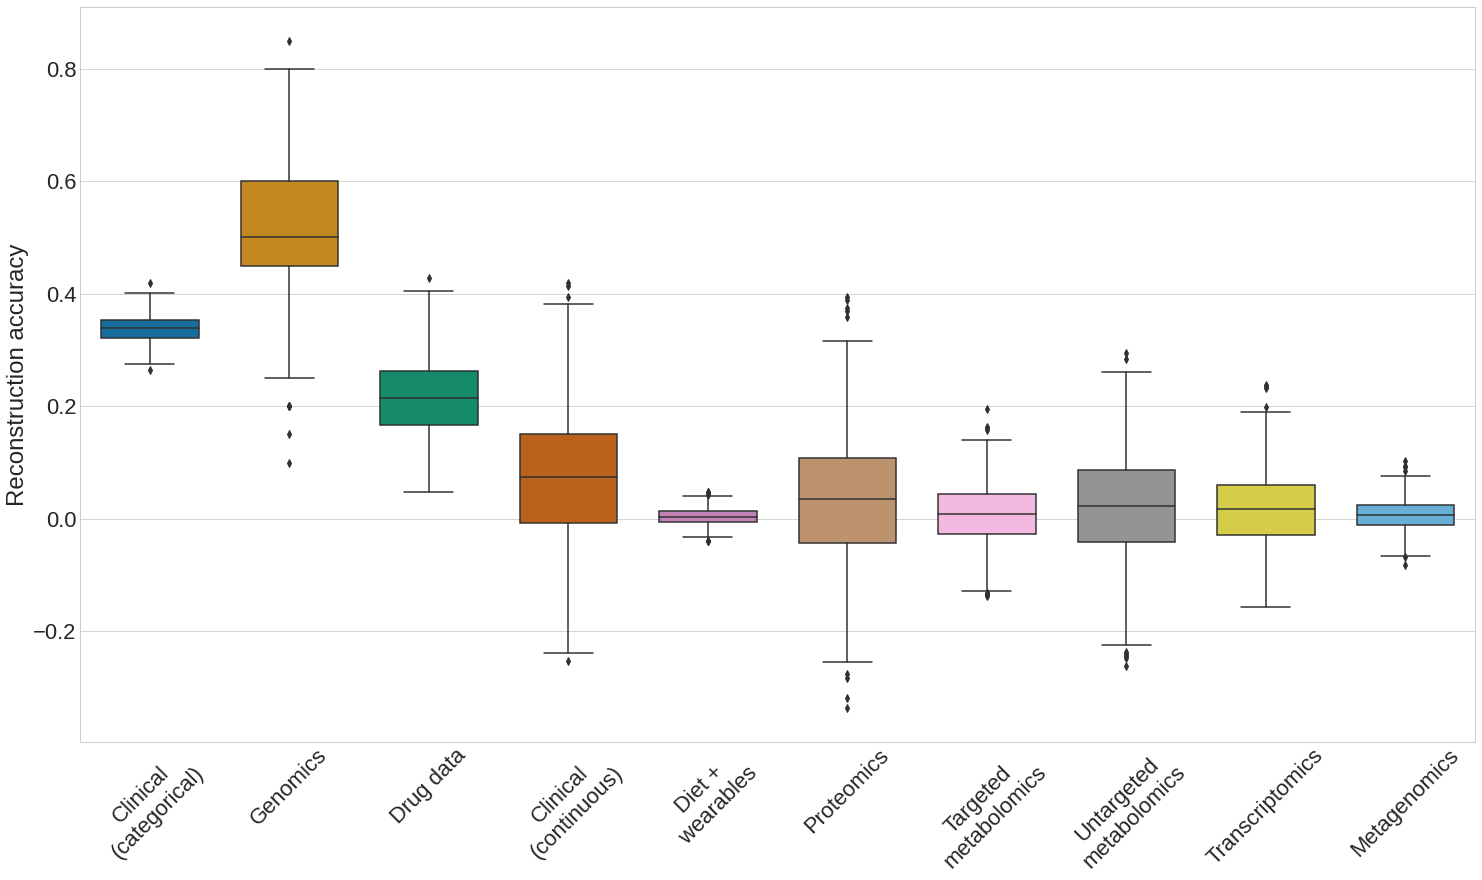

In [6]:
# Getting the reconstruction results
latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = get_latents(best_model, train_loader, 1)
cat_total_recon = calc_categorical_reconstruction_acc(cat_shapes, cat_class, cat_recon)
all_values = calc_continuous_reconstruction_acc(con_shapes, con_recon, train_loader)

# Plotting the reconstruction distributions   
plot_reconstruction_distribs(processed_data_path, cat_total_recon, all_values)

Visualizing the distributions of the features in the latent space in an UMAP embedding. 


 Getting the embeddings.


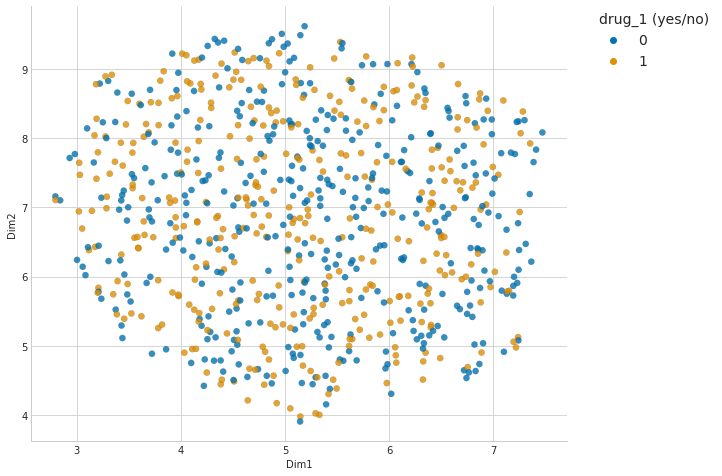

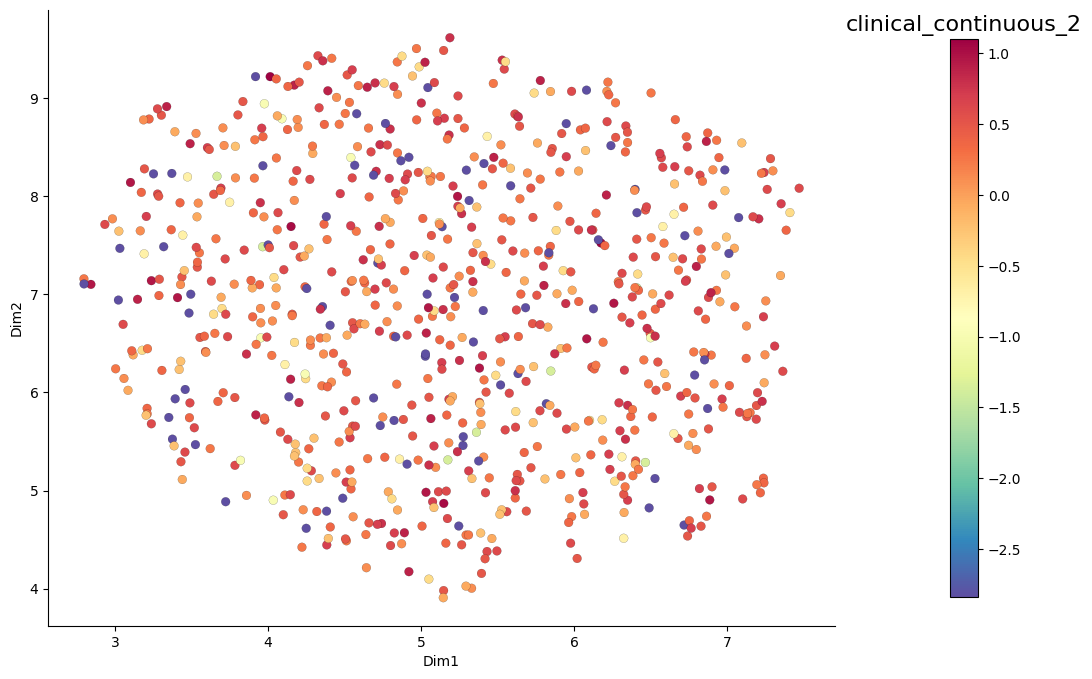

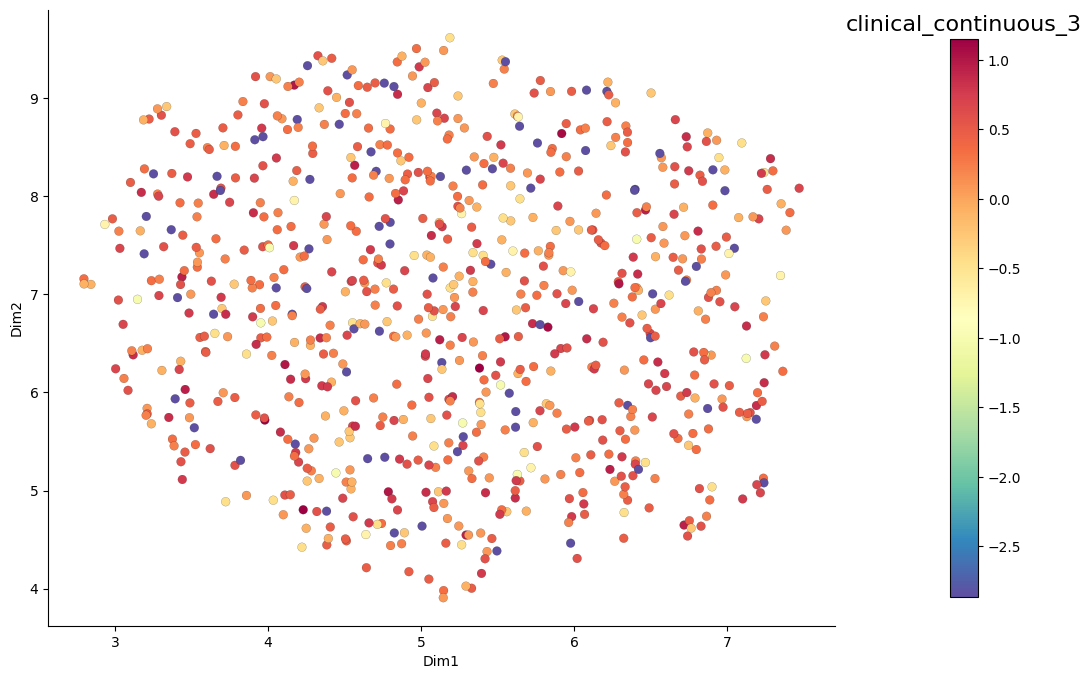

In [7]:
# Getting the embeddings
print('\n Getting the embeddings.')    
embedding = get_embedding(processed_data_path, latent)

# Visualizing the embedding of three example features
for feature in features_to_visualize:
    visualize_embedding(processed_data_path, feature, embedding, 
                        mask, cat_list, con_list, cat_names, con_names)

Providing an example of Pearson correlation calculation for two examples

In [8]:
# Getting pearson correlations of two example features
for feature in features_to_visualize:
    spear_corr = get_pearsonr(feature, embedding, cat_list, con_list, cat_names, con_names)
    print(f"Pearson correlation for the 1st embedding dim of {feature}: {round(spear_corr[0][0], 3)}, p-value={round(spear_corr[0][1], 3)}")
    print(f"Pearson correlation for the 2nd embedding dim of {feature}: {round(spear_corr[1][0], 3)}, p-value={round(spear_corr[1][1], 3)}")


Pearson correlation for the 1st embedding dim of drug_1: -0.067, p-value=0.06
Pearson correlation for the 2nd embedding dim of drug_1: 0.01, p-value=0.773
Pearson correlation for the 1st embedding dim of clinical_continuous_2: 0.074, p-value=0.037
Pearson correlation for the 2nd embedding dim of clinical_continuous_2: 0.014, p-value=0.692
Pearson correlation for the 1st embedding dim of clinical_continuous_3: 0.019, p-value=0.589
Pearson correlation for the 2nd embedding dim of clinical_continuous_3: -0.081, p-value=0.022


Feature importance inspired by SHAP by changing one variable at the time to missing and calculate change in the latent space. 

In [9]:
# Getting features importance measures
all_diffs, all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np,\
    total_diffs_cat_np = get_feature_importance_categorical(best_model, train_loader, latent)
all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np,\
        total_diffs_con_np = get_feature_importance_continuous(best_model, train_loader, mask, latent)

# Saving features importance measure results 
save_feat_results(processed_data_path, all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np, 
             all_diffs_con_np, sum_diffs_con_np,sum_diffs_con_abs_np, total_diffs_con_np)

# Plotting categorical importance measures
plot_categorical_importance(path=processed_data_path,
                        sum_diffs=sum_diffs_cat_np,
                        cat_list=cat_list,
                        feature_names=cat_names,
                        fig_name='importance_SHAP_cat')

# Plotting continuous importance measures
plot_continuous_importance(path=processed_data_path,
                       train_loader=train_loader,
                       sum_diffs=sum_diffs_con_np,
                       feature_names=con_names,
                       fig_name='importance_SHAP_con')

  0%|                                                                             | 0/393 [00:09<?, ?it/s]


====> Test set loss: 14.2207


  0%|                                                                              | 0/20 [00:07<?, ?it/s]


====> Test set loss: 14.1932


  0%|                                                                              | 0/42 [00:11<?, ?it/s]


====> Test set loss: 14.0998


  0%|                                                                  | 1/8361 [00:00<1:48:39,  1.28it/s]

====> Test set loss: 14.1571


  0%|                                                                  | 2/8361 [00:01<1:41:50,  1.37it/s]

====> Test set loss: 14.0980


  0%|                                                                  | 3/8361 [00:02<1:35:54,  1.45it/s]

====> Test set loss: 14.1253


  0%|                                                                  | 4/8361 [00:02<1:41:17,  1.38it/s]

====> Test set loss: 14.3222


  0%|                                                                  | 5/8361 [00:03<1:58:21,  1.18it/s]

====> Test set loss: 14.2141


  0%|                                                                  | 6/8361 [00:04<1:57:28,  1.19it/s]

====> Test set loss: 14.0151


  0%|                                                                  | 7/8361 [00:05<1:51:57,  1.24it/s]

====> Test set loss: 13.9969


  0%|                                                                  | 8/8361 [00:06<1:58:02,  1.18it/s]

====> Test set loss: 14.0971


  0%|                                                                  | 9/8361 [00:07<1:46:48,  1.30it/s]

====> Test set loss: 14.5922


  0%|                                                                 | 10/8361 [00:07<1:43:55,  1.34it/s]

====> Test set loss: 14.0811


  0%|                                                                 | 11/8361 [00:08<1:49:14,  1.27it/s]

====> Test set loss: 14.1876


  0%|                                                                 | 12/8361 [00:09<1:41:26,  1.37it/s]

====> Test set loss: 14.0959


  0%|                                                                 | 13/8361 [00:10<1:44:54,  1.33it/s]

====> Test set loss: 14.1036


  0%|                                                                 | 14/8361 [00:10<1:43:13,  1.35it/s]

====> Test set loss: 14.2070


  0%|                                                                 | 15/8361 [00:11<1:59:40,  1.16it/s]

====> Test set loss: 14.0626


  0%|                                                                 | 16/8361 [00:12<1:52:27,  1.24it/s]

====> Test set loss: 14.0614


  0%|▏                                                                | 17/8361 [00:13<2:13:19,  1.04it/s]

====> Test set loss: 14.0025


  0%|▏                                                                | 18/8361 [00:15<2:20:50,  1.01s/it]

====> Test set loss: 14.0330


  0%|▏                                                                | 19/8361 [00:15<1:56:45,  1.19it/s]

====> Test set loss: 14.1761


  0%|▏                                                                | 20/8361 [00:15<1:34:34,  1.47it/s]

====> Test set loss: 14.1705


  0%|▏                                                                | 21/8361 [00:16<1:21:25,  1.71it/s]

====> Test set loss: 14.0212


  0%|▏                                                                | 22/8361 [00:16<1:08:46,  2.02it/s]

====> Test set loss: 14.0832


  0%|▏                                                                | 23/8361 [00:16<1:00:26,  2.30it/s]

====> Test set loss: 14.3014


  0%|▏                                                                  | 24/8361 [00:17<55:11,  2.52it/s]

====> Test set loss: 14.0677


  0%|▏                                                                  | 25/8361 [00:17<54:52,  2.53it/s]

====> Test set loss: 14.3775


  0%|▏                                                                  | 26/8361 [00:17<57:03,  2.43it/s]

====> Test set loss: 14.0675


  0%|▏                                                                | 27/8361 [00:18<1:02:41,  2.22it/s]

====> Test set loss: 14.0986


  0%|▏                                                                | 28/8361 [00:19<1:19:14,  1.75it/s]

====> Test set loss: 13.9835


  0%|▏                                                                | 29/8361 [00:20<1:45:04,  1.32it/s]

====> Test set loss: 14.2616


  0%|▏                                                                | 30/8361 [00:21<1:39:51,  1.39it/s]

====> Test set loss: 14.0234


  0%|▏                                                                | 31/8361 [00:21<1:39:29,  1.40it/s]

====> Test set loss: 14.2286


  0%|▏                                                                | 32/8361 [00:22<1:26:10,  1.61it/s]

====> Test set loss: 14.1785


  0%|▎                                                                | 33/8361 [00:23<1:59:47,  1.16it/s]

====> Test set loss: 14.1316


  0%|▎                                                                | 34/8361 [00:24<1:52:36,  1.23it/s]

====> Test set loss: 14.0455


  0%|▎                                                                | 35/8361 [00:24<1:46:32,  1.30it/s]

====> Test set loss: 14.0725


  0%|▎                                                                | 36/8361 [00:26<2:18:07,  1.00it/s]

====> Test set loss: 13.9617


  0%|▎                                                                | 37/8361 [00:27<1:43:35,  1.34it/s]

====> Test set loss: 14.1135


KeyboardInterrupt: 

We also calculated the importance based on the weights from input to the first layer. This only represent the importance for defining the latent space (the encoder part). This was ony directy possible because our optimal setting only included one hidden layer. The categorical data is a sum of each input from the flatten one-hot encoding.

In [ ]:
# Getting feature importance on weights
get_feat_importance_on_weights(processed_data_path, best_model, train_loader, cat_names, con_names)


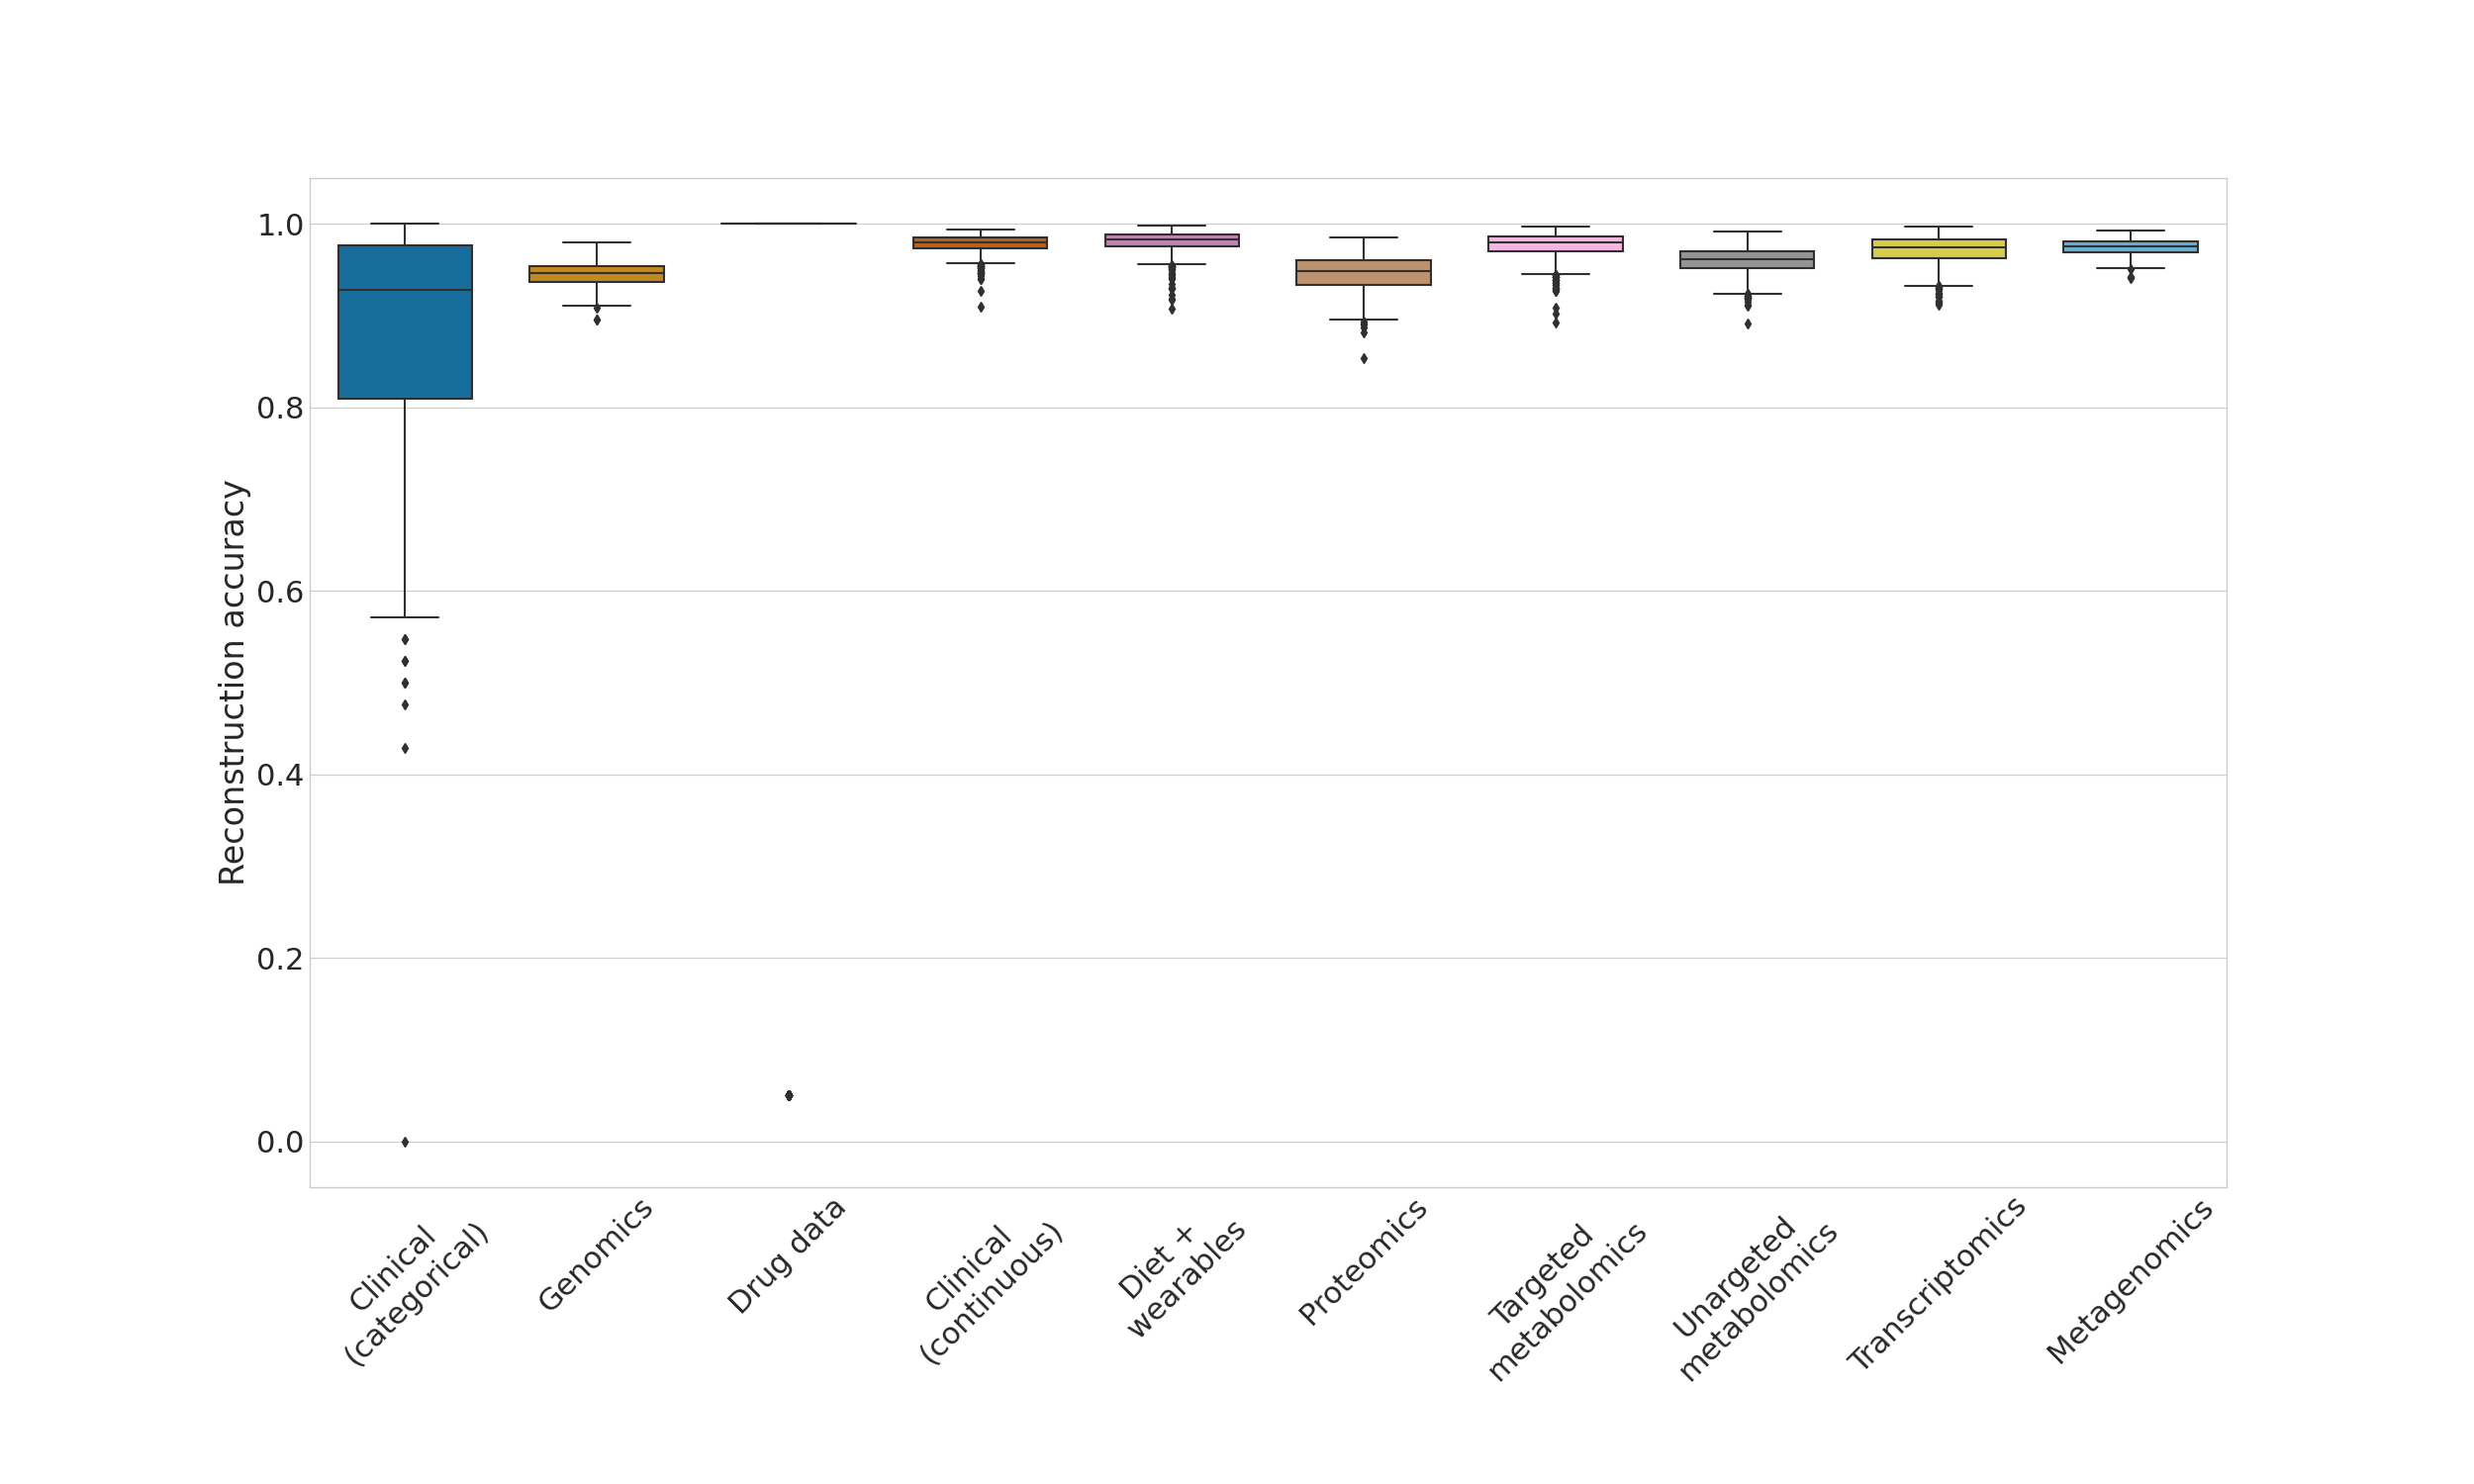

We can now plot the distributions of the features in the latent space in an UMAP embedding.  

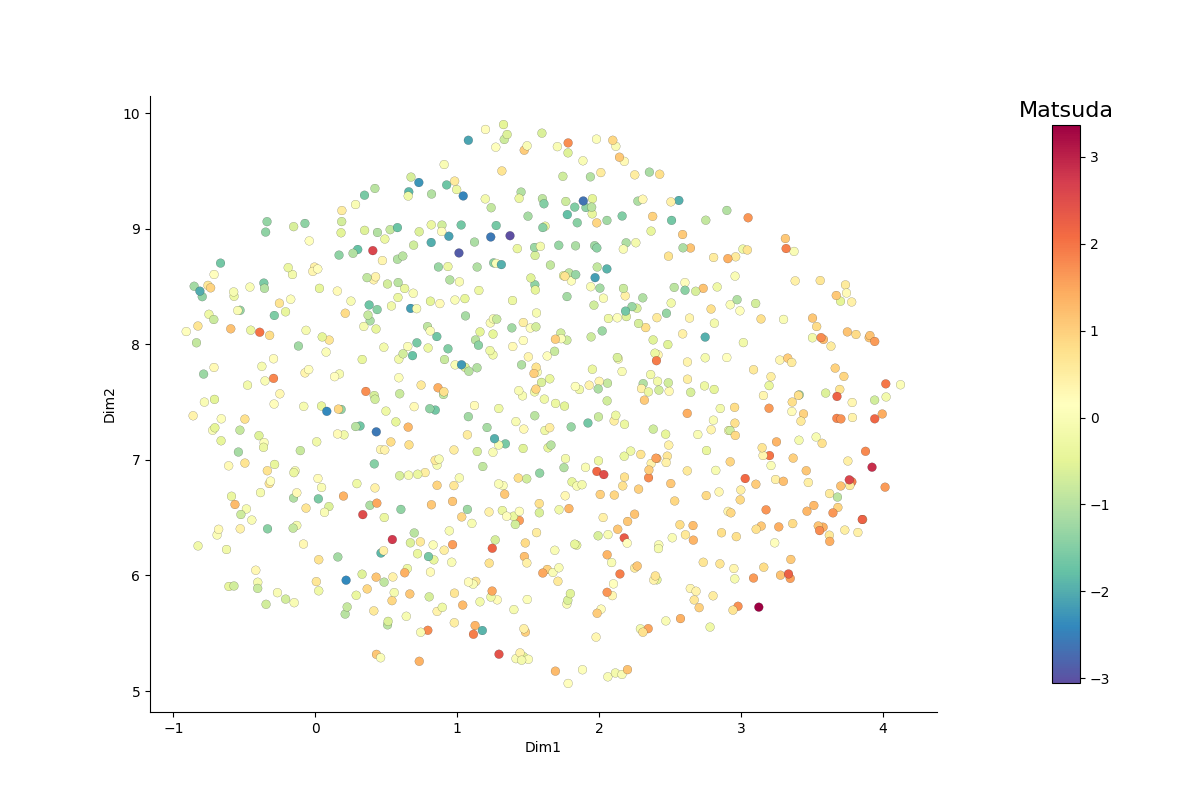

Feature importance inspired by SHAP by changing one variable at the time to missing and calculate change in the latent space. 

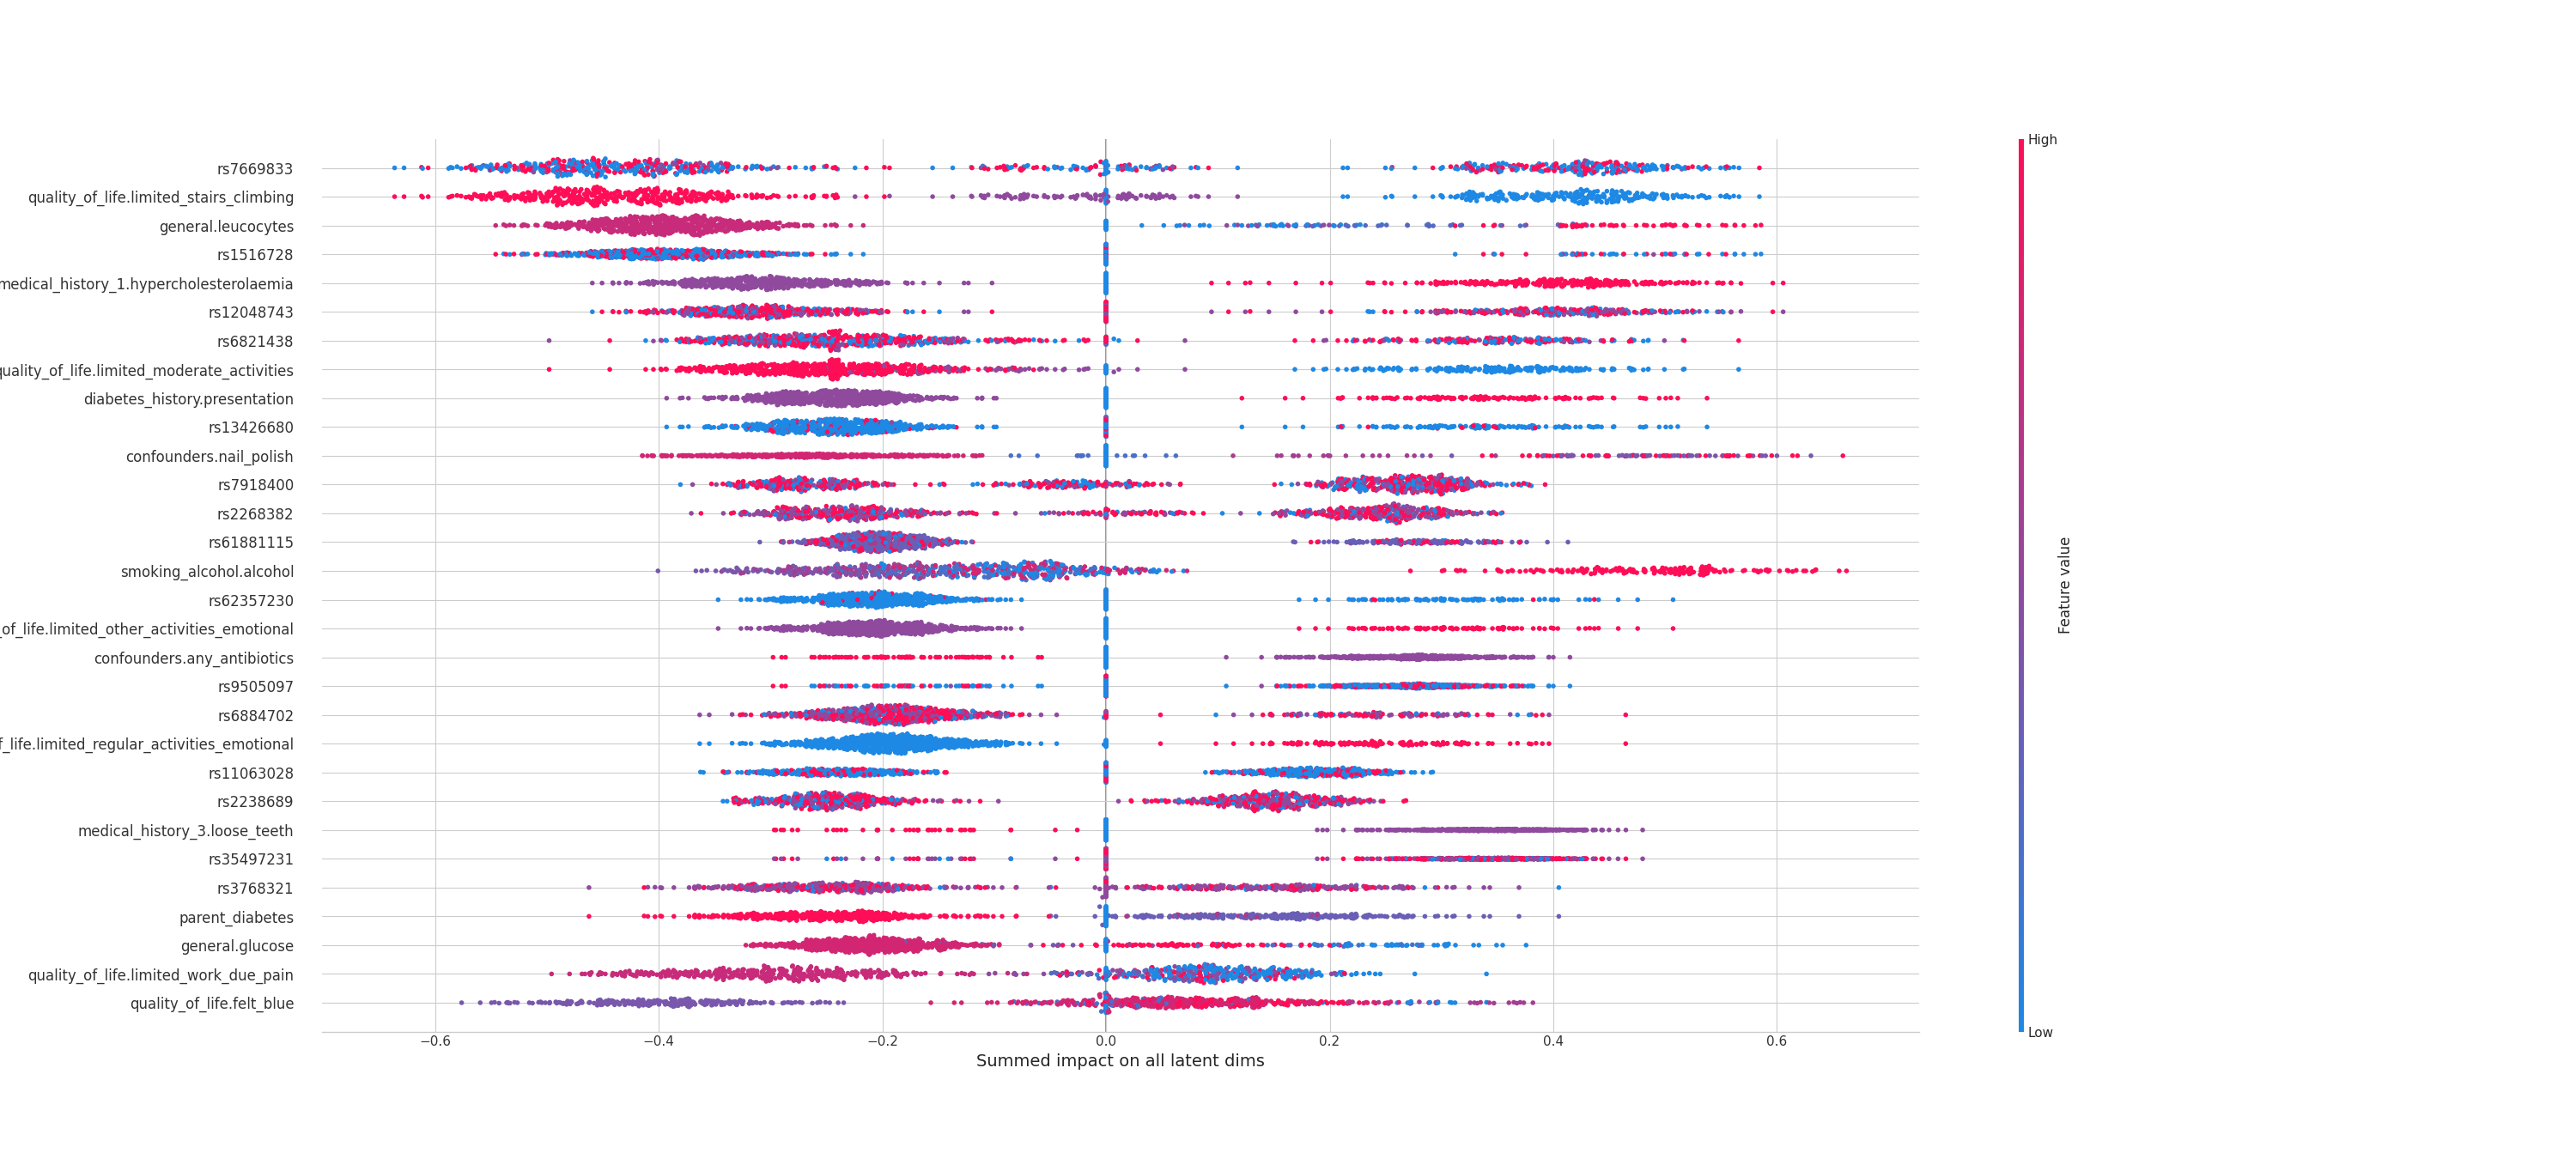

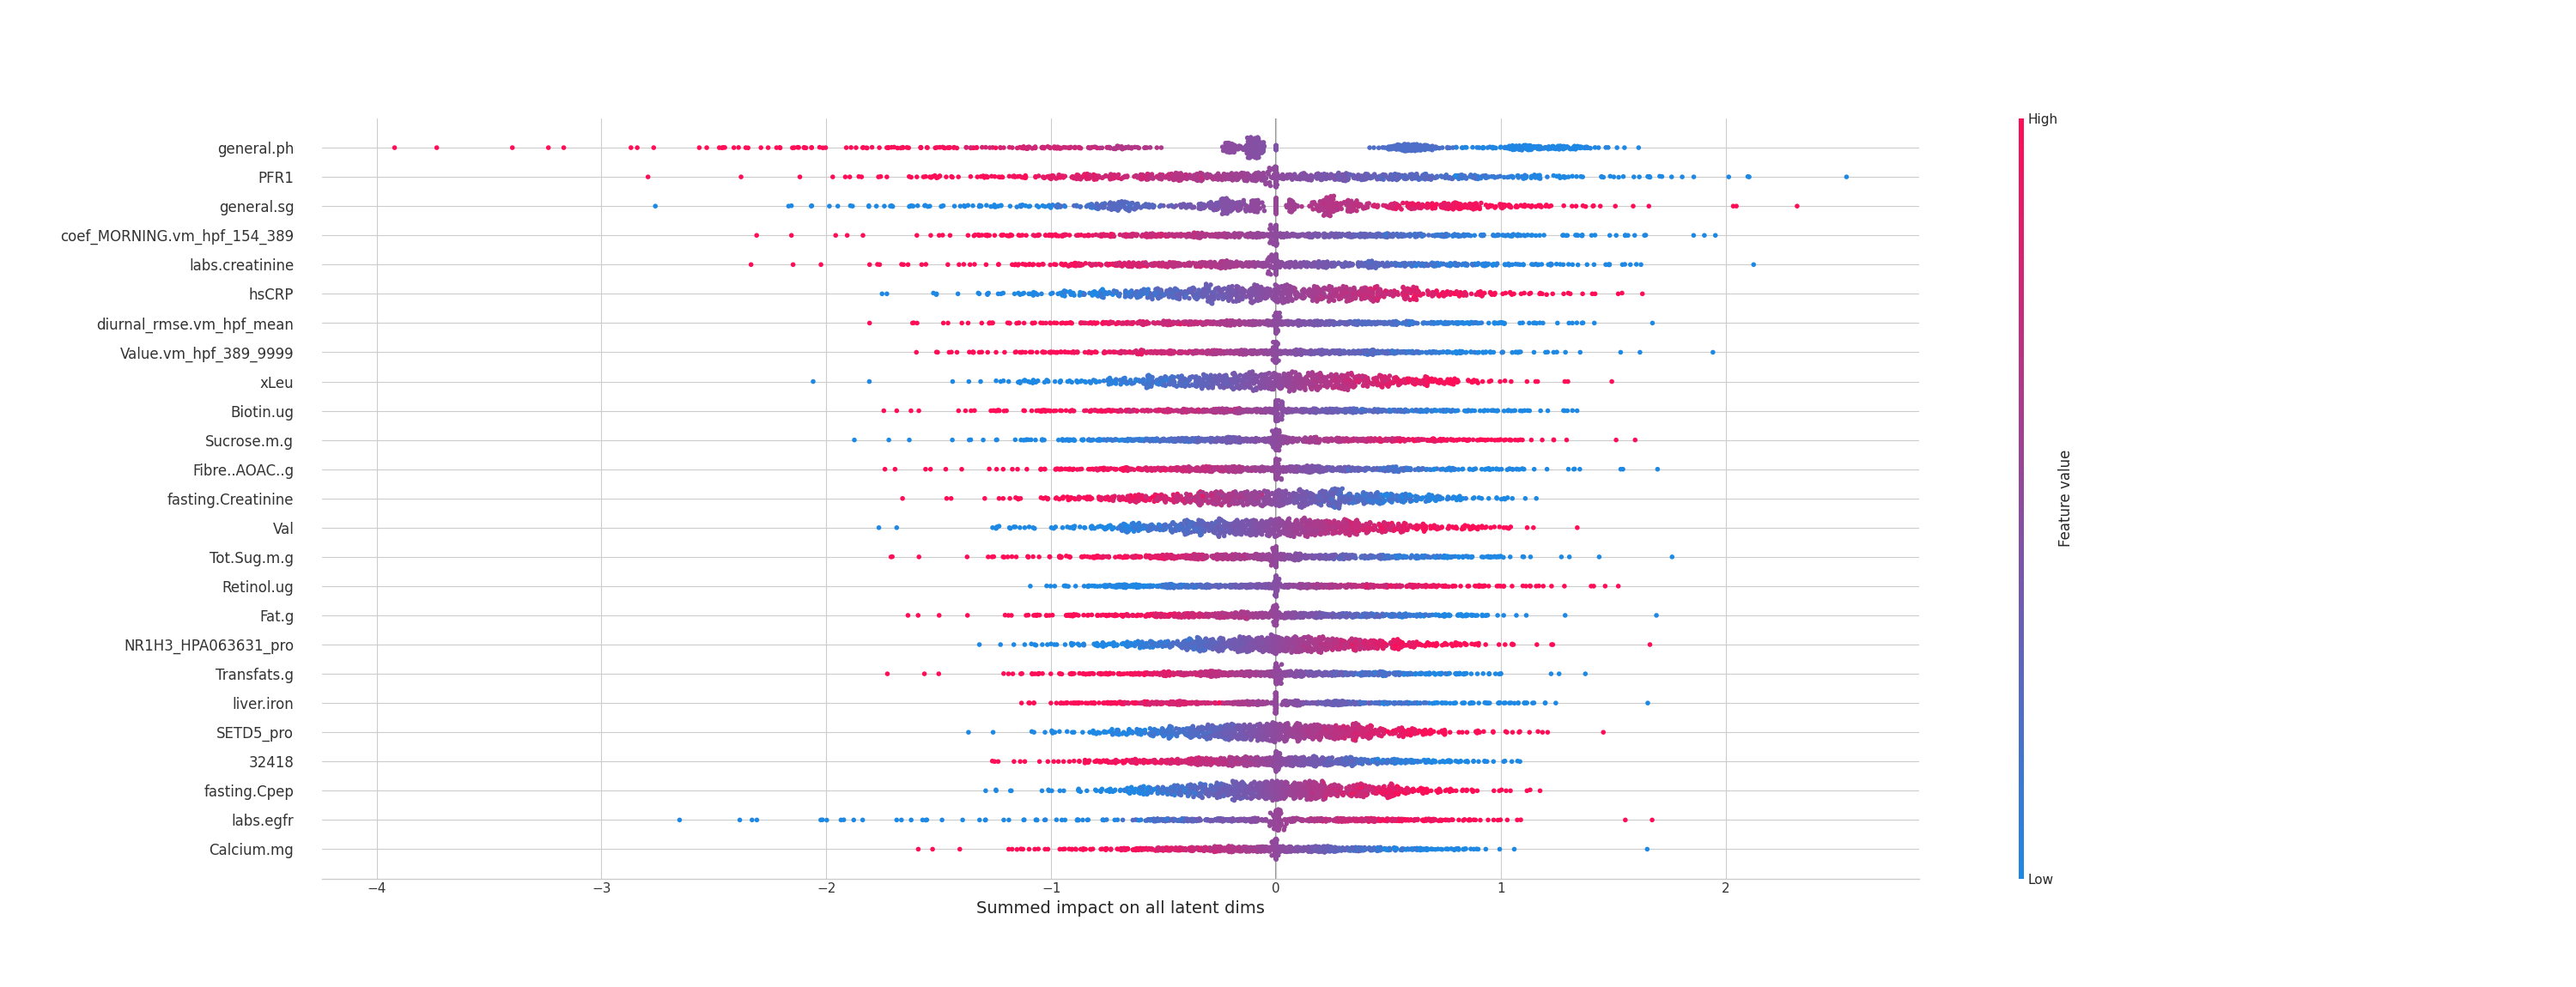

After this the <i>identify_drug_assosiation.ipynb</i> can be run for extracting assosiations learned by the networks